# pyIsoDep

Copyright (c) Dan Kotlyar

# A scenario with pre-generated XS and traces

##  Description

Example on how to execute a full depletion calculations.

## Load modules

In [1]:
import numpy as np
from pyIsoDep.functions.maindepletionsolver import MainDepletion
from pyIsoDep.functions.generatedata import TransmutationData
from pyIsoDep.functions.postprocessresults import Results
from pyIsoDep.functions.read_csv import ReadCsv
from pyIsoDep.functions.xsinterface import XsInterface

### Data Generation Stage

In [2]:
FY_WGT = 0.0  # determines the fission yield wieghting
VOL = 332097.8  # cm^3

xsTable, fields = ReadCsv("./bootstrap.csv")
xs0 = TransmutationData(libraryFlag=True, wgtFY=1.0)
xs0.ReadData(ID=xsTable[:, 0], sig_f=xsTable[:, 3], sig_c=xsTable[:, 2],
                   sig_alpha=xsTable[:, 4], flagBarns=True)

xsTable, fields = ReadCsv("./tempramp.csv")
xs1 = TransmutationData(libraryFlag=True, wgtFY=1.0)
xs1.ReadData(ID=xsTable[:, 0], sig_f=xsTable[:, 3], sig_c=xsTable[:, 2],
                  sig_alpha=xsTable[:, 4], flagBarns=True)

## XS Interface Stage

### Single Dependency: temperature

**Comment**: the cross sections used here were not really generated for multiple temperatures, but we will assume they are.

In [3]:
# Define the pre-generated sets for the different perturbations
xs = XsInterface(numdepn=1, numpert=3, states=[[500], [600], [700]],
                 xssets=[xs0, xs1, xs1], extrpFlag=True)
# Set-up the traces
timepoints, xsTimeSets = xs.setTimeTrace([0.0, 5.5, 30.0], [525, 550, 575])

### Two Dependencies: temperature and pressure

In [4]:
xs = XsInterface(numdepn=2, numpert=6, states=[[500, 2], [500, 3], [500, 4],
                                                [600, 2], [600, 3], [600, 4]],
                  xssets=[xs0, xs0, xs0, xs0, xs0, xs0], extrpFlag=True)

timepoints, xsTimeSets = xs.setTimeTrace([0, 3.5], [500, 550], [3.0, 3.5])

### Three dependencies: temperature, pressure, and xenon

**Comment**: the cross sections used here were not really generated for multiple temperatures, but we will assume they are.

In [5]:
xs = XsInterface(numdepn=3, numpert=18,
                 states=[[500, 2, 1E-05], [500, 2, 2E-05], [500, 2, 3E-05],
                         [500, 3, 1E-05], [500, 3, 2E-05], [500, 3, 3E-05],
                         [500, 5, 1E-05], [500, 5, 2E-05], [500, 5, 3E-05],
                         [600, 2, 1E-05], [600, 2, 2E-05], [600, 2, 3E-05],
                         [600, 3, 1E-05], [600, 3, 2E-05], [600, 3, 3E-05],
                         [600, 5, 1E-05], [600, 5, 2E-05], [600, 5, 3E-05]],
                 xssets=[xs0, xs0, xs0, xs0, xs0,
                         xs0, xs0, xs0, xs0, xs0,
                         xs0, xs0, xs0, xs0, xs0,
                         xs0, xs0, xs0], extrpFlag=True)
# Set-up the traces
timepoints, xsTimeSets =\
    xs.setTimeTrace([0.0, 50.0, 100.0], [525, 550, 575], [2.5, 3.5, 3.75], [1.5E-05, 2.5E-05, 2.75E-05])

### Depletion Stage

#### Execute Depletion

In [6]:
dep = MainDepletion(timepoints, *xsTimeSets)
# define metadata (steps, flux, and so on)
power = 1E+6*np.array([16.545, 118.49, 272.52, 330.22, 272.52, 214.82, 118.49])
dt = np.array([5.5, 24.5, 7., 1800., 7., 180., 40.])
dep.SetDepScenario(power=power, timeUnits="seconds", timesteps=dt)
# set initial composition
dep.SetInitialComposition(xsTable[:, 0], xsTable[:, 1], vol=VOL)
# solve the Bateman equations
dep.SolveDepletion(method="cram", xsinterp=False)

#### Post depletion analysis

In [7]:
dep.DecayHeat()
dep.Radiotoxicity()
dep.Activity()
dep.Mass()

### Post-process results

In [8]:
res = Results(dep)

In [9]:
res.getvalues("totalQt")

array([2.26062673e-03, 2.31077846e+05, 2.92441792e+06, 5.53613244e+06,
       1.57902852e+07, 1.48928810e+07, 1.16482768e+07, 8.88484757e+06])

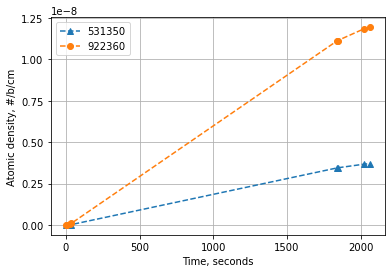

In [10]:
res.plot("Nt", timeUnits="seconds", markers=['--^', '--o'], isotopes=[531350, 922360],
         ylabel="Atomic density, #/b/cm")

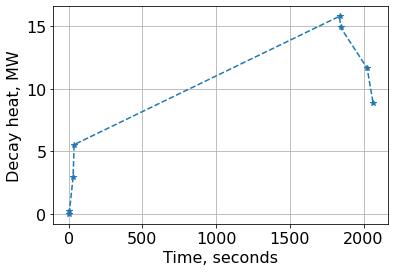

In [11]:
res.plot("totalQt", timeUnits="seconds", norm=1E+6, ylabel="Decay heat, MW")

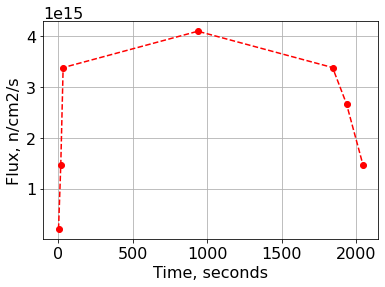

In [12]:
res.plot("flux", timeUnits="seconds", markers="--ro", ylabel="Flux, n/cm2/s")